In [1]:
import torch
import torchvision
from torchvision import transforms
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def load_train_valid_sets(data_dir='./data', valid_split=0.1, batch_size=64):
    
    transform = transforms.Compose(
        [
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            transforms.Normalize( 
                mean=[0.4914, 0.4822, 0.4465],
                std=[0.2023, 0.1994, 0.2010],
            )
        ]
    )
    
    trainset = torchvision.datasets.CIFAR10(root=data_dir, transform=transform, 
                                       train=True, download=True)
    
    
    train_size = int(len(trainset)*(1 - valid_split))
    valid_size = len(trainset) - train_size
    train, valid = torch.utils.data.random_split(trainset, [train_size, valid_size])
    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size)
    
    classes = {k : trainset.classes[k] for k in range(len(trainset.classes))}
    
    return train_loader, valid_loader, classes

In [22]:
def load_test_sets(data_dir='./data', batch_size=64):
    
    transform = transforms.Compose(
        [
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            transforms.Normalize( 
                mean=[0.4914, 0.4822, 0.4465],
                std=[0.2023, 0.1994, 0.2010],
            )
        ]
    )
    
    testset = torchvision.datasets.CIFAR10(root=data_dir, transform=transform, 
                                       train=False, download=True)
    
    
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

    return test_loader

In [23]:
train_loader, valid_loader, classes = load_train_valid_sets()

Files already downloaded and verified


In [24]:
test_loader = load_test_sets()

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

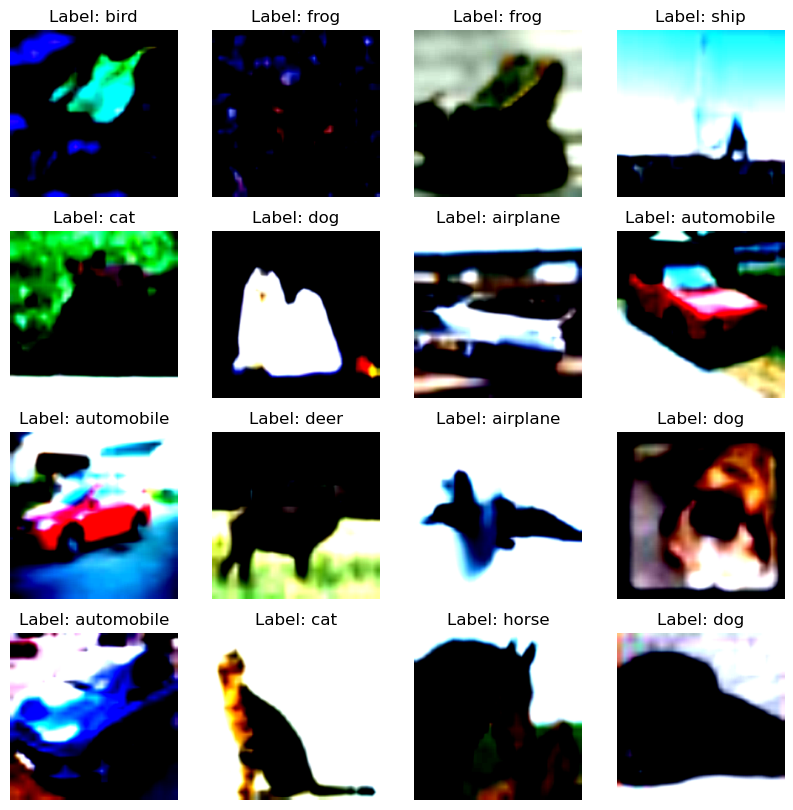

In [6]:
#random sample the dataset and plot on of the pictures
import matplotlib.pyplot as plt

data_iter = iter(train_loader)
cols, rows = 4,4
fig,ax = plt.subplots(rows, cols,figsize=(10,10))
for i in range(rows):
    images, labels = data_iter.next()
    for j in range(cols):
        ax[i][j].axis("off")
        ax[i][j].imshow(images[j].squeeze().permute(1, 2, 0))
        ax[i][j].set_title(f'Label: {classes[labels[j].item()]}')

In [7]:
class InceptionLayer(torch.nn.Module):
    
    def __init__(self, in_channels, num_1x1, num_3x3_red, num_3x3, num_5x5_red, num_5x5, pool_proj):
        super().__init__()
        self.path1x1 = torch.nn.Sequential(
            ConvLayer(in_channels, num_1x1, 1)
        )
        
        self.path3x3 = torch.nn.Sequential(
            ConvLayer(in_channels, num_3x3_red, 1),
            ConvLayer(num_3x3_red, num_3x3, 3, padding=1)
        )
        
        self.path5x5 = torch.nn.Sequential(
            ConvLayer(in_channels, num_5x5_red, 1),
            ConvLayer(num_5x5_red, num_5x5, 5, padding=2)
        )
        
        self.poolproj = torch.nn.Sequential(
            torch.nn.MaxPool2d(3, 1, padding=1),
            ConvLayer(in_channels, pool_proj, 1)
        )
        
    def forward(self, x):
        
        a = self.path1x1(x)
        b = self.path3x3(x)
        c = self.path5x5(x)
        d = self.poolproj(x)
        
        out = torch.cat([a,b,c,d],1)
        
        return out

In [8]:
class ConvLayer(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
        self.relu = torch.nn.ReLU()
        self.norm = torch.nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.relu(x)
        return x

In [53]:
class GoogLeNet(torch.nn.Module):
    
    def __init__(self, num_classes=10):
        super().__init__()
        
        self.layer1 = torch.nn.Sequential(
            ConvLayer(3, 64, 7, stride=2,padding=3),
            torch.nn.MaxPool2d(3, 2),
#             torch.nn.LOCALRESPONSENORM()    
        )
        
        self.layer2 = torch.nn.Sequential(
            ConvLayer(64, 64, 1),
            ConvLayer(64, 192, 3, padding=1),
#             torch.nn.LOCALRESPONSENORM()  
            torch.nn.MaxPool2d(3, 2, padding=1)  
        )
     
        self.inception3 = torch.nn.Sequential(
            InceptionLayer(192, 64, 96, 128, 16, 32, 32),
            InceptionLayer(256, 128, 128, 192, 32, 96, 64),
            torch.nn.MaxPool2d(3, 2, padding=1)
        )
        
        self.inception4 = torch.nn.Sequential(
            InceptionLayer(480, 192, 96, 208, 16, 48, 64),
            InceptionLayer(512, 160, 112, 224, 24, 64, 64),
            InceptionLayer(512, 128, 128, 256, 24, 64, 64),
            InceptionLayer(512, 112, 144, 288, 32, 64, 64),
            InceptionLayer(528, 256, 160, 320, 32, 128, 128),
            torch.nn.MaxPool2d(3, 2, padding=1)
        )
        
        self.inception5 = torch.nn.Sequential(
            InceptionLayer(832, 256, 160, 320, 32, 128, 128),
            InceptionLayer(832, 384, 192, 384, 48, 128, 128),
            torch.nn.AvgPool2d(7, 1)
        )
        
        self.fc = torch.nn.Sequential(
            torch.nn.Dropout(0.4),
            torch.nn.Linear(1024, num_classes)
        )
        
    def forward(self, x):
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.inception3(x)
        x = self.inception4(x) 
        x = self.inception5(x) 
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x

In [54]:
import torch.optim as optim

learning_rate = 0.005

net = GoogLeNet(len(classes)).to(device)

critereon = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.005)

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch, device, args):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top5],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()

    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        # move data to the same device as model
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        # compute output
        output = model(images)
        loss = criterion(output, target)

        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            progress.display(i + 1)

In [55]:
num_epochs = 2
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        output = net(images)
        loss = critereon(output, labels)
        
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(len(valid_loader), 100 * correct / total)) 
    

torch.Size([64, 10])
Epoch [1/2], Step [1/704], Loss: 2.3501
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])


KeyboardInterrupt: 

In [56]:
labels

tensor([4, 8, 2, 4, 3, 0, 3, 0, 1, 5, 3, 6, 3, 0, 2, 1, 2, 0, 3, 4, 1, 9, 7, 5,
        5, 6, 6, 8, 0, 1, 6, 6, 8, 3, 1, 1, 2, 4, 8, 2, 1, 6, 6, 4, 4, 0, 8, 9,
        1, 7, 5, 9, 2, 0, 7, 2, 8, 9, 5, 0, 8, 0, 9, 2])

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs
        
        if i % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, 100 * correct / total))

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))   

In [ ]:
import numpy as np
from torchvision import utils

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1):
    n,c,w,h = tensor.shape
    
    if allkernels:
        tensor = tensor.view(n*c, -1, w, h)
    elif c != 3:
        tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
        
    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.axis('off')
    plt.ioff()
    plt.show()

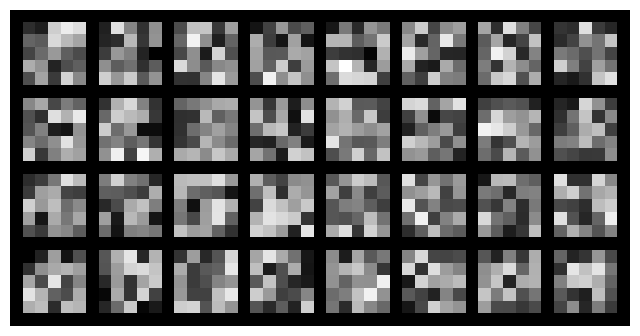

In [49]:
visTensor(net.inception3[0].path5x5[1].conv.weight)

In [45]:
net.inception3[0].path1x1[0].conv

Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))